./data/textures/Colored Brodatz/D9_COLORED.tif


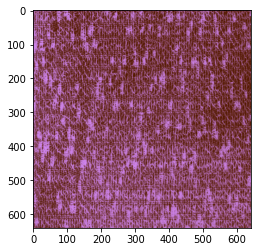

In [46]:
# Needed for the actual stuff
from glob import glob
import os
import cv2

import matplotlib.pyplot as plt

extension = '.tif'

# Just to visualise
from data import plot_multiple_images


folder_path = './data/textures/Colored Brodatz'
imgs = glob(os.path.join(folder_path,'*'+extension))

print(imgs[0])

img0 = cv2.imread(imgs[0])
img1 = cv2.imread(imgs[1])

# plot_multiple_images(0, [img0, img1], ipynb=True)
plt.imshow(img1)